# Work
請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:

## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model




In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
"""
使用迴圈建立不同的帶不同 L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 13s 257us/step - loss: 1.6180 - accuracy: 0.5231 - val_loss: 1.6750 - val_accuracy: 0.4986
Epoch 49/50
50000/50000 [==============================] - 12s 246us/step - loss: 1.6155 - accuracy: 0.5226 - val_loss: 1.6655 - val_accuracy: 0.5068
Epoch 50/50
50000/50000 [==============================] - 13s 253us/step - loss: 1.6072 - accuracy: 0.5248 - val_loss: 1.7237 - val_accuracy: 0.4772
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________

50000/50000 [==============================] - 10s 204us/step - loss: 1.0794 - accuracy: 0.6689 - val_loss: 1.5802 - val_accuracy: 0.5195
Epoch 46/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.0691 - accuracy: 0.6734 - val_loss: 1.5452 - val_accuracy: 0.5320
Epoch 47/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.0536 - accuracy: 0.6786 - val_loss: 1.5225 - val_accuracy: 0.5326
Epoch 48/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.0479 - accuracy: 0.6816 - val_loss: 1.6299 - val_accuracy: 0.5079
Epoch 49/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.0395 - accuracy: 0.6846 - val_loss: 1.5208 - val_accuracy: 0.5343
Epoch 50/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.0202 - accuracy: 0.6893 - val_loss: 1.5386 - val_accuracy: 0.5361
Experiment with Regulizer = 0.000000
Model: "model_1"
__________________________________________________________

50000/50000 [==============================] - 10s 200us/step - loss: 0.9686 - accuracy: 0.6588 - val_loss: 1.3819 - val_accuracy: 0.5223
Epoch 43/50
50000/50000 [==============================] - 11s 214us/step - loss: 0.9601 - accuracy: 0.6596 - val_loss: 1.3950 - val_accuracy: 0.5200
Epoch 44/50
50000/50000 [==============================] - 11s 228us/step - loss: 0.9501 - accuracy: 0.6665 - val_loss: 1.4157 - val_accuracy: 0.5146
Epoch 45/50
50000/50000 [==============================] - 11s 215us/step - loss: 0.9335 - accuracy: 0.6715 - val_loss: 1.3980 - val_accuracy: 0.5247
Epoch 46/50
50000/50000 [==============================] - 13s 259us/step - loss: 0.9259 - accuracy: 0.6726 - val_loss: 1.4410 - val_accuracy: 0.5134
Epoch 47/50
50000/50000 [==============================] - 12s 245us/step - loss: 0.9120 - accuracy: 0.6800 - val_loss: 1.3552 - val_accuracy: 0.5345
Epoch 48/50
50000/50000 [==============================] - 14s 273us/step - loss: 0.8944 - accuracy: 0.6852 - va

50000/50000 [==============================] - 10s 205us/step - loss: 1.0167 - accuracy: 0.6431 - val_loss: 1.3300 - val_accuracy: 0.5428
Epoch 40/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.0013 - accuracy: 0.6488 - val_loss: 1.4502 - val_accuracy: 0.5148
Epoch 41/50
50000/50000 [==============================] - 10s 208us/step - loss: 0.9895 - accuracy: 0.6537 - val_loss: 1.3704 - val_accuracy: 0.5295
Epoch 42/50
50000/50000 [==============================] - 10s 207us/step - loss: 0.9781 - accuracy: 0.6565 - val_loss: 1.3807 - val_accuracy: 0.5226
Epoch 43/50
50000/50000 [==============================] - 10s 208us/step - loss: 0.9617 - accuracy: 0.6620 - val_loss: 1.4319 - val_accuracy: 0.5137
Epoch 44/50
50000/50000 [==============================] - 10s 206us/step - loss: 0.9546 - accuracy: 0.6674 - val_loss: 1.3673 - val_accuracy: 0.5392
Epoch 45/50
50000/50000 [==============================] - 10s 205us/step - loss: 0.9413 - accuracy: 0.6690 - va

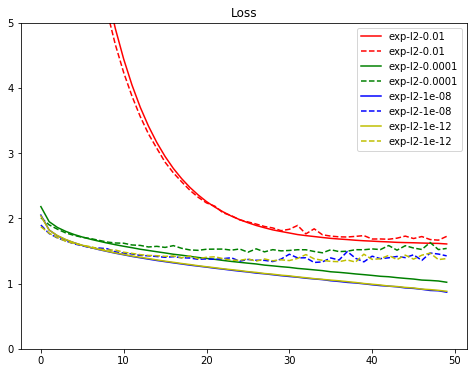

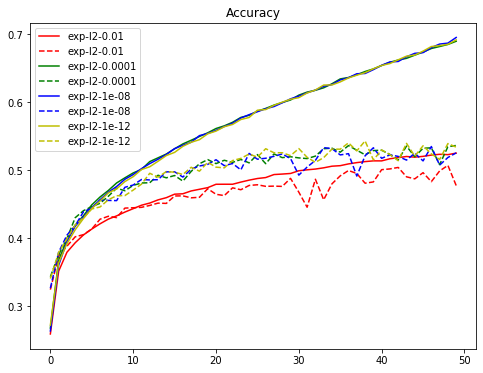

In [9]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [10]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model




In [13]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [15]:
results = {}
"""
使用迴圈建立不同的帶不同 L1 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 9s 190us/step - loss: 2.4626 - accuracy: 0.0981 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 10s 191us/step - loss: 2.4626 - accuracy: 0.0977 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 9s 189us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________________________

50000/50000 [==============================] - 9s 186us/step - loss: 2.8244 - accuracy: 0.6219 - val_loss: 3.1030 - val_accuracy: 0.5147
Epoch 46/50
50000/50000 [==============================] - 9s 186us/step - loss: 2.7840 - accuracy: 0.6220 - val_loss: 3.0173 - val_accuracy: 0.5275
Epoch 47/50
50000/50000 [==============================] - 9s 186us/step - loss: 2.7484 - accuracy: 0.6242 - val_loss: 3.0235 - val_accuracy: 0.5311
Epoch 48/50
50000/50000 [==============================] - 9s 188us/step - loss: 2.7091 - accuracy: 0.6246 - val_loss: 3.0196 - val_accuracy: 0.5205
Epoch 49/50
50000/50000 [==============================] - 10s 192us/step - loss: 2.6730 - accuracy: 0.6279 - val_loss: 3.0048 - val_accuracy: 0.5073
Epoch 50/50
50000/50000 [==============================] - 9s 187us/step - loss: 2.6368 - accuracy: 0.6297 - val_loss: 3.0663 - val_accuracy: 0.4802
Experiment with Regulizer = 0.000000
Model: "model_1"
_______________________________________________________________

50000/50000 [==============================] - 10s 192us/step - loss: 0.9698 - accuracy: 0.6592 - val_loss: 1.3847 - val_accuracy: 0.5246
Epoch 43/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.9554 - accuracy: 0.6632 - val_loss: 1.3913 - val_accuracy: 0.5233
Epoch 44/50
50000/50000 [==============================] - 10s 190us/step - loss: 0.9448 - accuracy: 0.6654 - val_loss: 1.4458 - val_accuracy: 0.5125
Epoch 45/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.9336 - accuracy: 0.6727 - val_loss: 1.3955 - val_accuracy: 0.5236
Epoch 46/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.9211 - accuracy: 0.6760 - val_loss: 1.3588 - val_accuracy: 0.5313
Epoch 47/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.9075 - accuracy: 0.6799 - val_loss: 1.3779 - val_accuracy: 0.5347
Epoch 48/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.8989 - accuracy: 0.6821 - val

50000/50000 [==============================] - 10s 194us/step - loss: 0.9983 - accuracy: 0.6479 - val_loss: 1.3249 - val_accuracy: 0.5370
Epoch 40/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.9834 - accuracy: 0.6536 - val_loss: 1.4550 - val_accuracy: 0.5112
Epoch 41/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.9765 - accuracy: 0.6562 - val_loss: 1.4322 - val_accuracy: 0.5136
Epoch 42/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.9636 - accuracy: 0.6607 - val_loss: 1.3911 - val_accuracy: 0.5205
Epoch 43/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.9498 - accuracy: 0.6679 - val_loss: 1.3893 - val_accuracy: 0.5237
Epoch 44/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.9360 - accuracy: 0.6702 - val_loss: 1.4054 - val_accuracy: 0.5180
Epoch 45/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.9285 - accuracy: 0.6750 - va

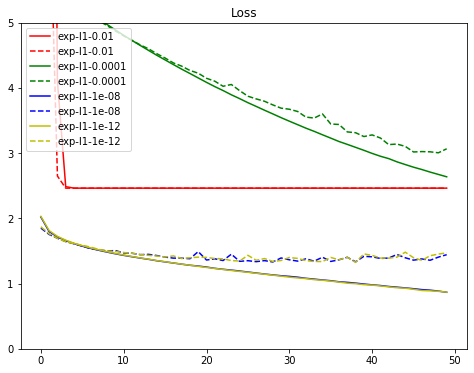

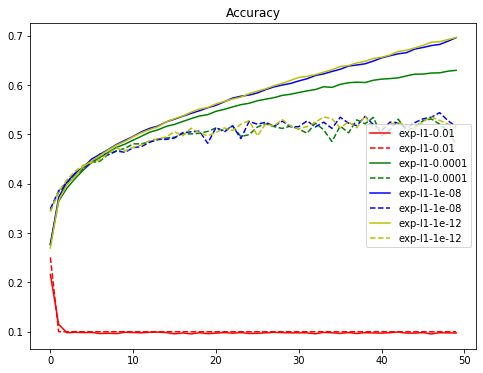

In [16]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [20]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 l1_l2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [21]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
l1_l2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [22]:
results = {}
"""
使用迴圈建立不同的帶不同 l1_l2 的模型並訓練
"""
for regulizer_ratio in l1_l2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 6s 127us/step - loss: 2.4614 - accuracy: 0.0977 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 6s 128us/step - loss: 2.4614 - accuracy: 0.0983 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 6s 127us/step - loss: 2.4614 - accuracy: 0.0977 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

50000/50000 [==============================] - 6s 129us/step - loss: 1.7668 - accuracy: 0.4761 - val_loss: 1.8074 - val_accuracy: 0.4651
Epoch 46/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.7638 - accuracy: 0.4754 - val_loss: 1.7956 - val_accuracy: 0.4655
Epoch 47/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.7591 - accuracy: 0.4793 - val_loss: 1.7984 - val_accuracy: 0.4637
Epoch 48/50
50000/50000 [==============================] - 6s 130us/step - loss: 1.7585 - accuracy: 0.4770 - val_loss: 1.7837 - val_accuracy: 0.4628
Epoch 49/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.7546 - accuracy: 0.4787 - val_loss: 1.7754 - val_accuracy: 0.4701
Epoch 50/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.7503 - accuracy: 0.4808 - val_loss: 1.7704 - val_accuracy: 0.4730
Experiment with Regulizer = 0.000000
Model: "model_1"
________________________________________________________________

Epoch 43/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6389 - accuracy: 0.5153 - val_loss: 1.6965 - val_accuracy: 0.4926
Epoch 44/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.6327 - accuracy: 0.5173 - val_loss: 1.6983 - val_accuracy: 0.4915
Epoch 45/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.6285 - accuracy: 0.5189 - val_loss: 1.6974 - val_accuracy: 0.4945
Epoch 46/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.6232 - accuracy: 0.5226 - val_loss: 1.8013 - val_accuracy: 0.4464
Epoch 47/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.6219 - accuracy: 0.5206 - val_loss: 1.6898 - val_accuracy: 0.4918
Epoch 48/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6144 - accuracy: 0.5238 - val_loss: 1.7038 - val_accuracy: 0.4839
Epoch 49/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.6148 - accuracy: 0.5228

50000/50000 [==============================] - 7s 131us/step - loss: 1.6587 - accuracy: 0.5123 - val_loss: 1.7000 - val_accuracy: 0.4912
Epoch 41/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.6500 - accuracy: 0.5134 - val_loss: 1.6960 - val_accuracy: 0.4996
Epoch 42/50
50000/50000 [==============================] - 6s 130us/step - loss: 1.6448 - accuracy: 0.5157 - val_loss: 1.7513 - val_accuracy: 0.4695
Epoch 43/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6389 - accuracy: 0.5172 - val_loss: 1.7247 - val_accuracy: 0.4799
Epoch 44/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.6346 - accuracy: 0.5166 - val_loss: 1.6880 - val_accuracy: 0.4995
Epoch 45/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.6289 - accuracy: 0.5171 - val_loss: 1.6812 - val_accuracy: 0.4962
Epoch 46/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6251 - accuracy: 0.5207 - val_loss:

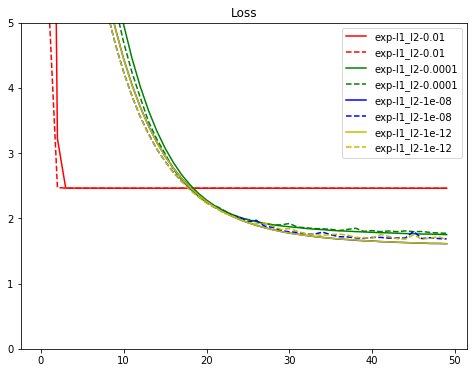

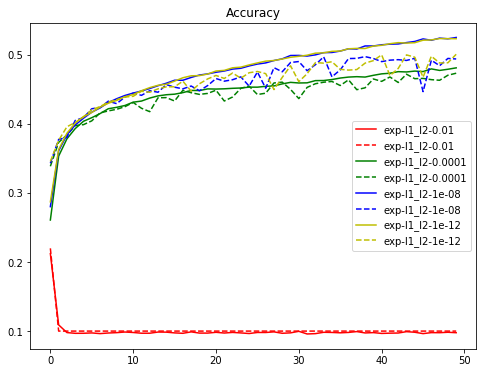

In [23]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

由上述可知,模型使用L2演算法,其泛化程度較佳及殘差收斂表現相較L1及L1_L2演算法更為穩定.